In [21]:
#importing Libraries
import pickle
import numpy as np
import pandas as pd
import os
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import random

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
root_dir = 'gdrive/My\ Drive/Research/Codes/LSTM'
data_dir = 'gdrive/MyDrive/Research/Codes/data/'
# !ls gdrive/MyDrive/Research/Codes/LSTM/data

# Reading Data

In [4]:
# reading MIDI files
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [ ]:
#reading file names
files=[i for i in os.listdir(data_dir) if i.endswith(".mid")]

#reading each file
notes_array = np.array([read_midi(data_dir+i) for i in files])


# Understanding & Preprocessing Data

In [6]:
#understanding data
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

396


In [7]:
#distribution of notes

#computing frequency of each note
freq = dict(Counter(notes_))

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [8]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

137


In [9]:
#top frequent notes
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

<ipython-input-9-87511c7a181a>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_music = np.array(new_music)


In [10]:
#prepping data
no_of_timesteps = 128
n_vocab = len(set(frequent_notes))
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        # print(note_)
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)


x=np.array(x)
y=np.array(y)

In [11]:
#encoding notes of the input sequence
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))


In [12]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)

#reshaping
x_seq = np.reshape(x_seq, (len(x_seq), no_of_timesteps, 1))
#normalizing the inputs
x_seq = x_seq / float(n_vocab) 

x_seq = np.array(x_seq)

In [13]:
#encoding notes of the output sequence
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

#reshaping
y_seq = np.reshape(y_seq,(-1,1))


In [ ]:
# splitting data for training and testing
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

# Model Creation & Training

In [24]:
def lstm():
  model = Sequential()
  model.add(LSTM(256, input_shape=(x_seq.shape[1], x_seq.shape[2]),return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(128))
  model.add(Dropout(0.2))
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dense(len(x_note_to_int)))
  model.add(Activation('softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
  return model

In [19]:
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)


In [ ]:
model = lstm()
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=200, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])


In [26]:
#loading best model
model = load_model('best_model.h5')

# Generating Sequences

In [ ]:
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(100):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

In [28]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [34]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    fp = 'music' + str(random.randint(0, 1000000000000000)) + '.mid'
    midi_stream.write('midi', fp=fp)

In [30]:
print(predicted_notes)

['B-3', 'F3', 'F3', 'F3', '2.6.9', '2.6.9', '2.6.9', '2.6.9', '1.7', '1.7', '1.7', '1.7', '1.7', '1.7', '1.7', '1.7', '1.7', '1.7', '1.7', '0.3', '9', '1.7', '0.3', '9', '9', '1.7', '1.7', '0.3', '9', '1.7', '0.3', '9', '1.7', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', 'G6', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '1.6', '1.7', '1.7', '1.7', '1.7', '1.7', '1.7', '1.7', '1.7', '1.7', '1.7', '1.7', '1.7', '0.3', '1.7', '0.3', '9', '1.7', '1.7', '1.7', '9', '1.7', '1.7', '1.7', '1.7', '10', '1.7', '10', '1.7', '10', '1.7', '10', '10', '1.7', '10', '10', '1.7', '1.7', '1.7', '1.7', '1.7', '10', '10', '10', '1.7', '1.7', '1.7', '1.7']


In [35]:
convert_to_midi(predicted_notes)


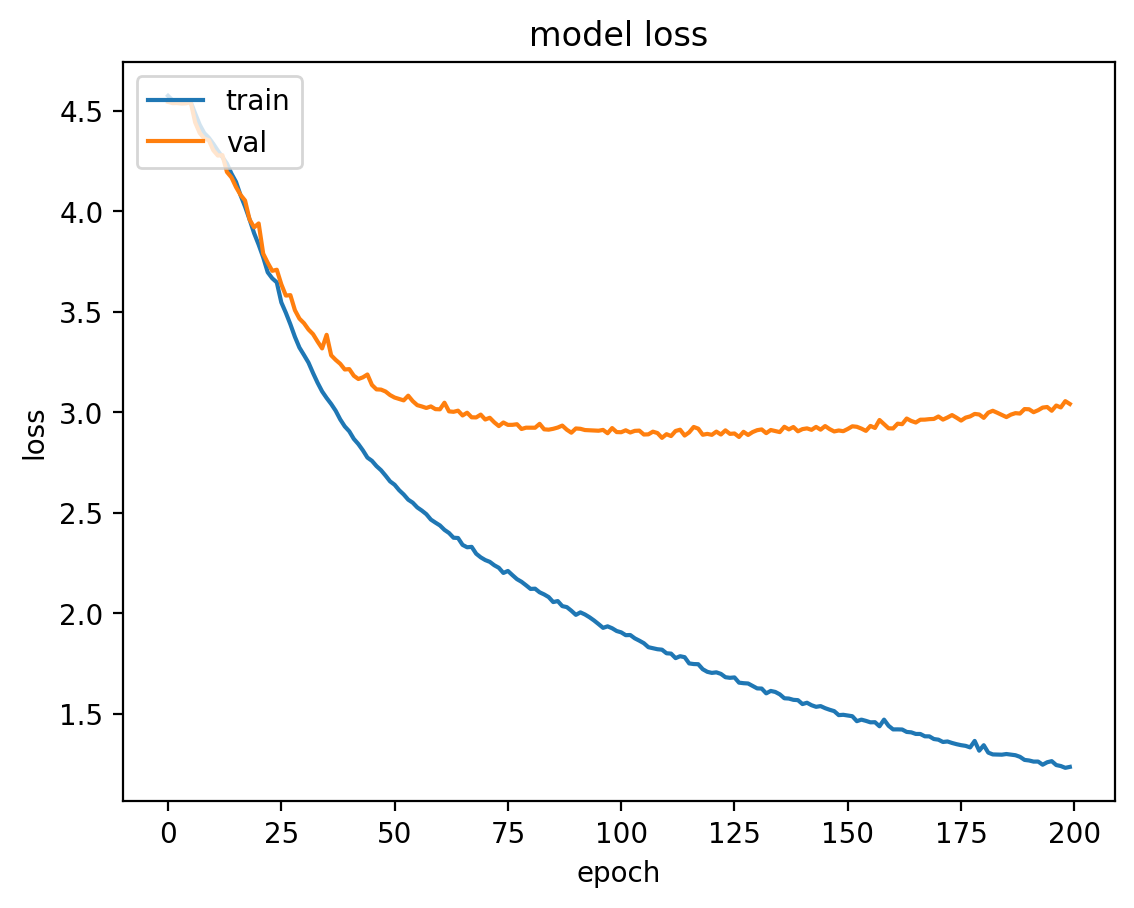

In [36]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128, 256)          264192    
                                                                 
 dropout_6 (Dropout)         (None, 128, 256)          0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 137)              